# Population Balance Equation: cell division and expansion in tomato

PINN reimplementation of the notebook https://github.com/LeonardoMiele/FruitGrowth/blob/main/Tomate_PBE.ipynb which accompanies the article  **Cell expansion-division under resource sharing: a novel framework for modeling fruit growth dynamics**, Leonardo Miele, Lionel Roques, Dario Constantinescu, Michel Génard, Nadia Bertin (https://doi.org/10.1101/2024.05.30.596571)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


Import our package

In [2]:
import jinns


2024-07-12 17:14:48.326532: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


Create a DataGenerator object

In [4]:
n = 10000
nb = 2
nt = 10000
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 2
dim = 1
xmin = 0
xmax = 30
tmin = 0
tmax = 1
method = "uniform"

Tmax = 10
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 2],
    #[jnp.exp] #[jax.nn.softplus]
]
key, subkey = random.split(key)
# HARD constraint to enforce 0 at x=0
output_transform = lambda pinn_in, pinn_out: (
         (xmax - pinn_in[1]) / (xmax - xmin) * 0.
         + (pinn_in[1] - xmin) * pinn_out


         #    + (pinn_in[1] - xmin) / (xmax - xmin) * 0.
         #+ (pinn_in[1] - xmin) * (xmax - pinn_in[1]) * pinn_out

     )
u_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)#, output_transform=output_transform)

In [6]:
init_nn_params_pinn = u_pinn.init_params()

## Set up the initial condition

In [7]:
SCALE = 1e6

In [8]:
# Initial condition parameters
x0 = 0.1
K2 = 1e2
kk = 223.2
n = 12
cell_num0 = 3300

(10000, 2)


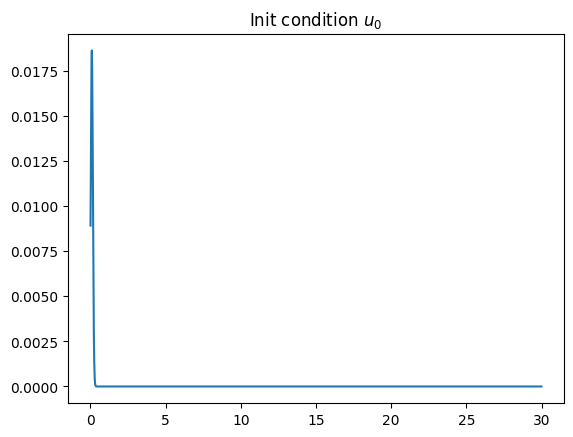

In [9]:
def u0(x):
    nP = cell_num0 * jnp.sqrt(K2) * jnp.exp(-K2 * (x[0] - x0) ** 2) / jnp.sqrt(jnp.pi)
    nQ = jnp.zeros_like(x[0])
    return jnp.array([nP, nQ]) / SCALE

v_u0 = jax.vmap(u0)
print(v_u0(train_data.omega.sort(axis=0)).shape)

plt.plot(train_data.omega.sort(axis=0), jnp.sum(v_u0(train_data.omega.sort(axis=0)), axis=1))
plt.title(r"Init condition $u_0$")
plt.show()

## Model parameters

In [10]:
init_params_pinn = {
    "nn_params":init_nn_params_pinn,
    "eq_params":{
        "r":jnp.array(0.3301),
        "rho":jnp.array(0.6143),
        "K":jnp.array(9.8137*1e6),
        "h":jnp.array(0.1044),
        "omega":jnp.zeros((temporal_batch_size * omega_batch_size,)) # just a place holder for the non local quantity # NOTE the size taken as the cartesian product 
    }
}

## Loss construction

In [11]:
from jinns.loss._DynamicLossAbstract import PDENonStatio
from jax import grad

class PBETomato(PDENonStatio):

    def __init__(self, Tmax=1):
        super().__init__(Tmax, None)
    def evaluate(self, t, x, u, params):

        omega = 1 - params["eq_params"]["omega"] / (params["eq_params"]["K"] / SCALE)
        def phi(x):
            return params["eq_params"]["r"] * x[0] ** (2/3)
        def gamma(x):
            n = 12
            gamma0 = 223.2
            return gamma0 * x[0] ** n / (params["eq_params"]["h"] ** n + x[0] ** n)
        

        nP = lambda t, x: u(t, x, params)[0]
        nQ = lambda t, x: u(t, x, params)[1]
        dnP_dt = grad(nP, 0)(t, x)
        dnQ_dt = grad(nQ, 0)(t, x)
        dPhinP_dx = grad(lambda t, x: phi(x) * nP(t, x), 1)(t, x)
        dPhinQ_dx = grad(lambda t, x: phi(x) * nQ(t, x), 1)(t, x)

        dyn_lossP = -dnP_dt + self.Tmax * (omega * (-dPhinP_dx + 4 * gamma(2 * x) * nP(t, 2 * x) - gamma(x) * nP(t, x)) - params["eq_params"]["rho"] * nP(t, x))
        #dyn_lossP = -dnP_dt + self.Tmax * params["eq_params"]["rho"] * nP(t, x)
        dyn_lossQ = -dnQ_dt + self.Tmax * (omega * (-dPhinQ_dx) + params["eq_params"]["rho"] * nP(t, x))
        return jnp.concatenate([dyn_lossP, dyn_lossQ], axis=0)

pbe_tomato = PBETomato(Tmax=Tmax)

In [12]:
from jinns.loss._LossPDE import LossPDEStatio, _LOSS_WEIGHT_KEYS_PDENONSTATIO
from jax.tree_util import register_pytree_node_class
from jinns.utils._utils import _get_vmap_in_axes_params, _set_derivatives, _update_eq_params_dict
from jinns.loss._Losses import *
import warnings

@register_pytree_node_class
class NonLocalLossPDENonStatio(LossPDEStatio):
    
    def __init__(
        self,
        u,
        loss_weights,
        dynamic_loss,
        derivative_keys=None,
        omega_boundary_fun=None,
        omega_boundary_condition=None,
        omega_boundary_dim=None,
        initial_condition_fun=None,
        norm_borders=None,
        norm_samples=None
    ):
        super().__init__(
            u,
            loss_weights,
            dynamic_loss,
            derivative_keys,
            omega_boundary_fun,
            omega_boundary_condition,
            omega_boundary_dim,
            None,
            norm_borders,
            norm_samples,
            sobolev_m=None,
            obs_slice=None,
        )
        if initial_condition_fun is None:
            warnings.warn(
                "Initial condition wasn't provided. Be sure to cover for that"
                "case (e.g by. hardcoding it into the PINN output)."
            )
        self.initial_condition_fun = initial_condition_fun

        for k in _LOSS_WEIGHT_KEYS_PDENONSTATIO:
            if k not in self.loss_weights.keys():
                self.loss_weights[k] = 0

    def __call__(self, *args, **kwargs):
        return self.evaluate(*args, **kwargs)

    def evaluate(
        self,
        params,
        batch,
    ):

        times_batch = batch.times_x_inside_batch[:, 0:1]
        omega_batch = batch.times_x_inside_batch[:, 1:]
        n = omega_batch.shape[0]

        vmap_in_axes_x_t = (0, 0)

        # Retrieve the optional eq_params_batch
        # and update eq_params with the latter
        # and update vmap_in_axes
        if batch.param_batch_dict is not None:
            eq_params_batch_dict = batch.param_batch_dict

            # feed the eq_params with the batch
            for k in eq_params_batch_dict.keys():
                params["eq_params"][k] = eq_params_batch_dict[k]

        vmap_in_axes_params = _get_vmap_in_axes_params(batch.param_batch_dict, params)

        # Compute the non local term using the argument `norm_samples`
        # We compute for all the time points in the batch
        # The double vmap enables to have different size for t (which will be the temporal_batch_size)
        # and for x which will be `norm_samples`
        v_S = vmap(
            vmap(
                lambda t, x, params_: jnp.sum(self.u(t, x, params_)) * x[0] ** (2/3),
                in_axes=(None, 0) + vmap_in_axes_params,
            ),
            in_axes=(0, None) + vmap_in_axes_params,
        )
        
        params_ = _set_derivatives(params, "dyn_loss", self.derivative_keys)
        params_["eq_params"]["omega"] = self.int_length * jnp.mean(v_S(times_batch, self.norm_samples, params_), axis=1)
        #jax.debug.print("{omega}", omega=params["eq_params"]["omega"])
        # When computing the dynamic loss only we have batch of omega for the dynamic loss
        vmap_in_axes_params_dynamic = ({"nn_params": None, "eq_params": {k: (0 if k == "omega" else None) for k in params_["eq_params"].keys()}},)
        # dynamic part
        #params_ = _set_derivatives(params, "dyn_loss", self.derivative_keys)
        if self.dynamic_loss is not None:
            mse_dyn_loss = dynamic_loss_apply(
                self.dynamic_loss.evaluate,
                self.u,
                (times_batch, omega_batch),
                params_,
                vmap_in_axes_x_t + vmap_in_axes_params_dynamic,
                self.loss_weights["dyn_loss"],
            )
        else:
            mse_dyn_loss = jnp.array(0.0)

        # boundary part
        params_ = _set_derivatives(params, "boundary_loss", self.derivative_keys)
        if self.omega_boundary_fun is not None:
            mse_boundary_loss = boundary_condition_apply(
                self.u,
                batch,
                params_,
                self.omega_boundary_fun,
                self.omega_boundary_condition,
                self.omega_boundary_dim,
                self.loss_weights["boundary_loss"],
            )
        else:
            mse_boundary_loss = jnp.array(0.0)

        # initial condition
        params_ = _set_derivatives(params, "initial_condition", self.derivative_keys)
        if self.initial_condition_fun is not None:
            mse_initial_condition = initial_condition_apply(
                self.u,
                omega_batch,
                params_,
                (0,) + vmap_in_axes_params,
                self.initial_condition_fun,
                n,
                self.loss_weights["initial_condition"],
            )
        else:
            mse_initial_condition = jnp.array(0.0)

        # total loss
        total_loss = (
            mse_dyn_loss
            + mse_boundary_loss
            + mse_initial_condition
        )
        #jax.debug.print("{x}", x=(mse_dyn_loss, mse_boundary_loss, mse_initial_condition))
        return total_loss, (
            {
                "dyn_loss": mse_dyn_loss,
                "norm_loss": 0.,
                "boundary_loss": mse_boundary_loss,
                "initial_condition": mse_initial_condition,
                "observations": 0.,
                "sobolev": 0.,
            }
        )

    def tree_flatten(self):
        children = (self.norm_samples, self.loss_weights)
        aux_data = {
            "u": self.u,
            "dynamic_loss": self.dynamic_loss,
            "derivative_keys": self.derivative_keys,
            "omega_boundary_fun": self.omega_boundary_fun,
            "omega_boundary_condition": self.omega_boundary_condition,
            "omega_boundary_dim": self.omega_boundary_dim,
            "initial_condition_fun": self.initial_condition_fun,
            "norm_borders": self.norm_borders,
            "sobolev_m": self.sobolev_m,
            "obs_slice": self.obs_slice,
        }
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        ( norm_samples, loss_weights) = children
        pls = cls(
            aux_data["u"],
            loss_weights,
            aux_data["dynamic_loss"],
            aux_data["derivative_keys"],
            aux_data["omega_boundary_fun"],
            aux_data["omega_boundary_condition"],
            aux_data["omega_boundary_dim"],
            aux_data["initial_condition_fun"],
            aux_data["norm_borders"],
            norm_samples,
        )
        return pls


Loss for the PINN

In [13]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax, "boundary_loss":1 * Tmax}

omega_boundary_fun = {
    "xmin": lambda t, x: jnp.array([0.0, 0.0]),
    "xmax": None,
}
omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": None,
}

key, subkey = jax.random.split(key, 2)
MC_samples = random.uniform(
            subkey, shape = (300, 1), minval=xmin, maxval=xmax
        )
loss_pinn = NonLocalLossPDENonStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=pbe_tomato,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    initial_condition_fun=u0,
    norm_borders=(xmin, xmax),
    norm_samples=MC_samples
)

## Learning the neural network parameters

### Train the PINN and plot loss values and solution

In [14]:
params_pinn = init_params_pinn
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)
n_iter = 15000
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _, _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
)

[train] Iteration 0: loss value = 179.0758514404297
[train] Iteration 1000: loss value = 0.007504546083509922
[train] Iteration 2000: loss value = 0.0060972729697823524
[train] Iteration 3000: loss value = 0.004889046773314476
[train] Iteration 4000: loss value = 0.0041960556991398335
[train] Iteration 5000: loss value = 0.002803281182423234
[train] Iteration 6000: loss value = 0.0022245387081056833
[train] Iteration 7000: loss value = 0.001954729435965419
[train] Iteration 8000: loss value = 0.0019201765535399318
[train] Iteration 9000: loss value = 0.0016140196239575744
[train] Iteration 10000: loss value = 0.0027656173333525658
[train] Iteration 11000: loss value = 0.002811677986755967
[train] Iteration 12000: loss value = 0.001823143451474607
[train] Iteration 13000: loss value = 0.003340821247547865
[train] Iteration 14000: loss value = 0.0023127668537199497
Stopping main optimization loop, cause: max iteration is reached
Final iteration 15000: train loss value = 0.002351857488974

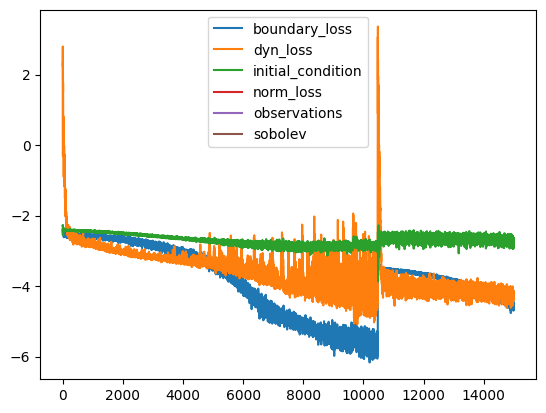

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
#plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

In [16]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

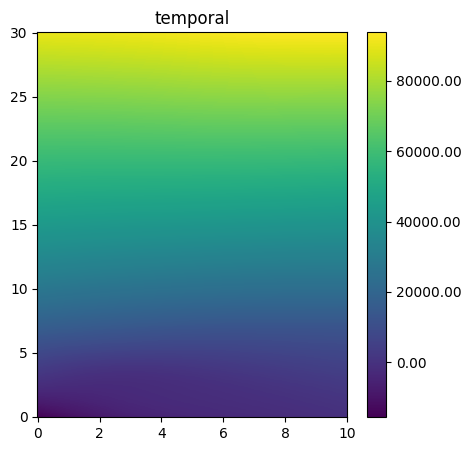

In [17]:
u_est_pinn_nP = lambda t, x: u_pinn(t, x, params_pinn["nn_params"])[0] * SCALE
u_est_pinn_nQ = lambda t, x: u_pinn(t, x, params_pinn["nn_params"])[1] * SCALE

u_est_pinn = lambda t, x: u_est_pinn_nP(t, x) + u_est_pinn_nQ(t, x)
# same subkey
jinns.data.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal")

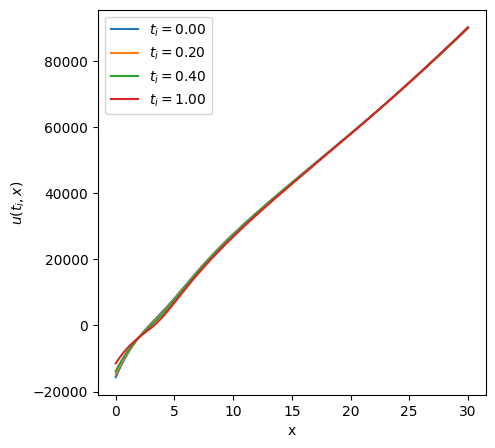

In [18]:
time_slices = [0., 0.2, 0.4, 1]

# rewrite the plot1d_slices from jinns.data_display in order to put a semilogx command
plt.figure(figsize=(5,5))
for t in time_slices:
    v_u_tfixed = vmap(partial(u_est_pinn, t=t * jnp.ones((1,))), 0, 0)
    values = v_u_tfixed(x=val_xdata[:, None])
    plt.plot(val_xdata, values, label=f"$t_i={t * Tmax:.2f}$")
    plt.xlabel("x")
    plt.ylabel(r"$u(t_i, x)$")
    plt.legend()
    plt.title("")
